#### Springboard capstone project 1   
## Correlations between poverty, food environment and diabetes in the United States
#### by Shuangshuang Liu
#### January 2020

[1. Introduction](#1.Introduction)  
[2. Data wrangling and EDA](#2.-Data-wrangling-and-EDA)  
[3. Statistical analysis](#3.-Statistical-analysis)  
[4. Predicting Diabetes--Supervised learning models](#4.-Predicting-Diabetes--Supervised-learning-models)  
 - [4.1 Linear regression](#4.1-Linear-regression)    
 - [4.2 Decision Trees](#4.2-Decision-Trees)  
 - [4.3 Random Forest](#4.3-Random-Forest)  
 - [4.4 XGBoost](#4.4-XGBoost)   
 
[5. Finding patterns of food environment among counties (unsupervised learning)](#5.-Finding-patterns-of-food-environment-among-counties-(unsupervised-learning))  
 - [5.1 PCA](#5.1-PCA)  
 - [5.2 K-means clustering](#5.2-K-means-clustering)  

# 1. Introduction

Diabetes is a chronic, metabolic disease characterized by elevated levels of blood glucose (or blood sugar), which leads over time to serious damage to the heart, blood vessels, eyes, kidneys, and nerves (definition by World Health Organization, WHO). It is considered a major cause of blindness, kidney failure heart attacks, stroke and lower limb amputation, and is estimated to be the seventh leading cause of death in 2016. Type 2 diabetes, which is usually found in adults, is the most common type and its prevalence has increased significantly during the past three decades. 

According to data from WHO, by 2014 there are 422 million people with diabetes, up from 108 million in 1980. In the United States, more than 30 million people (all ages, 2015) have diabetes and 1 in 4 of them do not know they have it. Moreover, in the last 20 years the number of adults diagnosed with diabetes has more than doubled as the American population has aged and become more overweight or obese (Diabetes quick facts, Centers for Disease Control and Prevention). An overview of U.S. adult diabetes rate is shown below: 


<img src='Figs/diabetes2013.png'>

Measures to prevent or delay the onset of type 2 diabetes include **healthy diet**, **regular physical activity**, **maintaining a normal body weight** and **avoiding tobacco use** (International Diabetes Federation).  Interestingly, the prevalence of diabetes has increased more rapidly in middle- and low- income countries (Diabetes fact sheets, WHO). This suggests that financial well-being may be correlated with the level of prevalence of diabetes. One explanation is that people in a poverty-persistent community may have less access to healthy foods and fitness facilities such as football fields and gyms, or have less incentives to maintain a healthy lifestyle due to financial hardship. 

Recent research on U.S. counties showed that low poverty/low-minority population counties had the greatest access to farmer’s markets and grocery stores, and that access to full services restaurants were significantly associated with lower prevalence of diabetes (Haynes-Maslow and Leone, 2017). However, the analysis in Haynes-Maslow and Leone (2017) has a few cavities, for example they categorized poverty level into low and high poverty groups which costed information loss; only used a multiple linear regression model on a handful of features and did not control for outliers. Other research had also found that high poverty neighborhoods have fewer supermarkets (Bower, et al., 2013), or a lower availability of healthy foods due to differential placement of types of stores and offerings of healthy foods within similar stores (Franco, et al., 2008).

Despite of previous research, we still lack a clear picture of the role of economic and food-environment indicators on diabetes prevalence. For example, which indicator is a better predictor of diabetes rate of a county, the poverty level or the availability of healthy foods? Are there any patterns in the food environment across U.S. counties? 

In this analysis, we hypothesized that poverty level and local food culture/environment, as measured by factors such as access to grocery stores, among other possible factors, may contribute to unhealthy life style and thus be associated with diabetes prevalence. The hypothesis can be summarized in the following diagram.

<img src='Figs/factors_diabetes.png'>

Specifically, we asked:   
 - 1) Are there significant differences in adult diabetes rate between metro and non-metro counties (i.e., urbanity, which is related to access to different types of stores), as well as poverty-persistent and non-poverty counties? 

 - 2) What are the most important features that may contribute to diabetes rate? Among those features which ones are more significantly correlated with diabetes rate, indicators of poverty level or food environment?

 - 3) Are there any patterns of food environment across U.S. counties? 

We will utilize the "Food Environment Atlas" database (https://www.ers.usda.gov/data-products/food-environment-atlas/) and apply a suite of machine learning algorithms (supervised and unsupervised learning) to address the above questions.   
 

## 2. Data wrangling and EDA

The Food Environment Atlas dataset (compiled by Economic Research Service, U.S. Department of Agriculture) is used in this analysis. The dataset contains 275 features of the food environment factors in three broad categories for 3143 U.S. counties:

 - 1) Food Choices—Indicators of the community access to and acquisition of healthy, affordable food, such as: access and proximity to a grocery store; number of food stores and restaurants; expenditures on fast foods; food and nutrition assistance program participation; food prices; food taxes; and availability of local foods.

 - 2) Health and Well-Being—Indicators of the community success in maintaining healthy diets, such as: food insecurity; diabetes and obesity rates; and physical activity levels.

 - 3) Community Characteristics—Indicators of community characteristics that might influence the food environment, such as: demographic composition; income and poverty; population loss; metro-nonmetro status; natural amenities; and recreation and fitness centers.


#### 2.1 Feature selection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline

In [2]:
df = pd.read_csv('data_atlas/atlas.csv') # County data for all features
allfeatures = pd.read_csv('data_atlas/processed/variables.csv',index_col='Category Code') # Feature names and details

## Filter out features not to be considered ##
# 1)Remove variables that measure '% change' between years, labeled as 'classification' and 'Legend'
feature_filter1 = allfeatures.loc[(allfeatures['Units']!='% change')
                                  &(allfeatures['Units']!='Classification')
                                  &(allfeatures['Units']!='Legend')]


# 2) For features that have two or more years, choose the most recent one only
# Split variable name in order to sort by years
feature_filter2 = pd.DataFrame(feature_filter1['Variable Name'].str.rsplit(', ',1).tolist(), columns=['Variable','Year']) 
feature = pd.concat([feature_filter1.reset_index(),feature_filter2],axis=1)

# Sort by year and only keep the most recent year
feature = feature.sort_values(by='Year', ascending=False)
feature = feature.drop_duplicates(subset='Variable',keep='first')
feature = feature.set_index('Category Code')

# Slice dataframe with the selected features plus county info
df = df.loc[:,['FIPS','State','County'] + feature['Variable Code'].tolist()] # Select data with updated features

In [3]:
# Yielded 138 features
print(feature.shape) 
print(df.shape)

(138, 9)
(3143, 141)


In [4]:
# Calculate state average values for each feature
states = (df.drop(['FIPS','County'], axis=1)).groupby('State').mean()
states.head()

,PCT_SNAP16,FOODHUB16,PCT_FMRKT_BAKED16,PCT_FMRKT_WICCASH16,FMRKT_ANMLPROD16,FMRKT_BAKED16,FMRKT_OTHERFOOD16,PCT_FMRKT_OTHERFOOD16,SNAPS16,FMRKT_CREDIT16,...,PCT_NHBLACK10,PCT_NHWHITE10,PCH_SBP_09_15,PCH_CACFP_09_15,PCH_WIC_09_15,PCH_SFSP_09_15,PCH_NSLP_09_15,FOODINSEC_CHILD_03_11,CH_FOODINSEC_12_15,CH_VLFOODSEC_12_15
State,,,,,,,,,,,,,,,,,,,,,
AK,11.555155,0.034483,44.722222,14.930556,1.250000,1.666667,1.583333,43.333333,17.812500,1.500000,...,1.131494,50.622066,0.974895,0.047075,-1.030685,0.456487,-0.406381,8.0,1.2,0.0
AL,16.976436,0.014925,40.419840,4.817708,0.765625,0.937500,1.046875,47.581298,72.636816,0.750000,...,28.250668,66.101869,0.723991,0.139507,-0.271065,0.462219,-1.380526,9.3,-0.3,0.5
AR,13.647462,0.013333,47.870813,7.030835,1.000000,1.000000,1.017544,48.221691,34.865556,0.824561,...,15.771596,76.993259,0.687514,0.760854,-0.429053,0.438172,-1.402372,11.5,0.0,-0.4
AZ,13.527693,0.200000,57.625466,35.696362,4.615385,4.461538,4.692308,50.985098,254.811111,5.615385,...,1.646774,52.825171,1.008930,-0.070693,-0.719922,0.046385,-0.456826,10.9,-0.5,-0.7
CA,10.961725,0.206897,52.136262,13.864407,6.392857,7.321429,7.125000,52.348241,412.377193,7.017857,...,3.041599,57.095504,1.148466,0.551509,-0.661636,0.069882,-0.231813,10.8,-3.0,-1.2


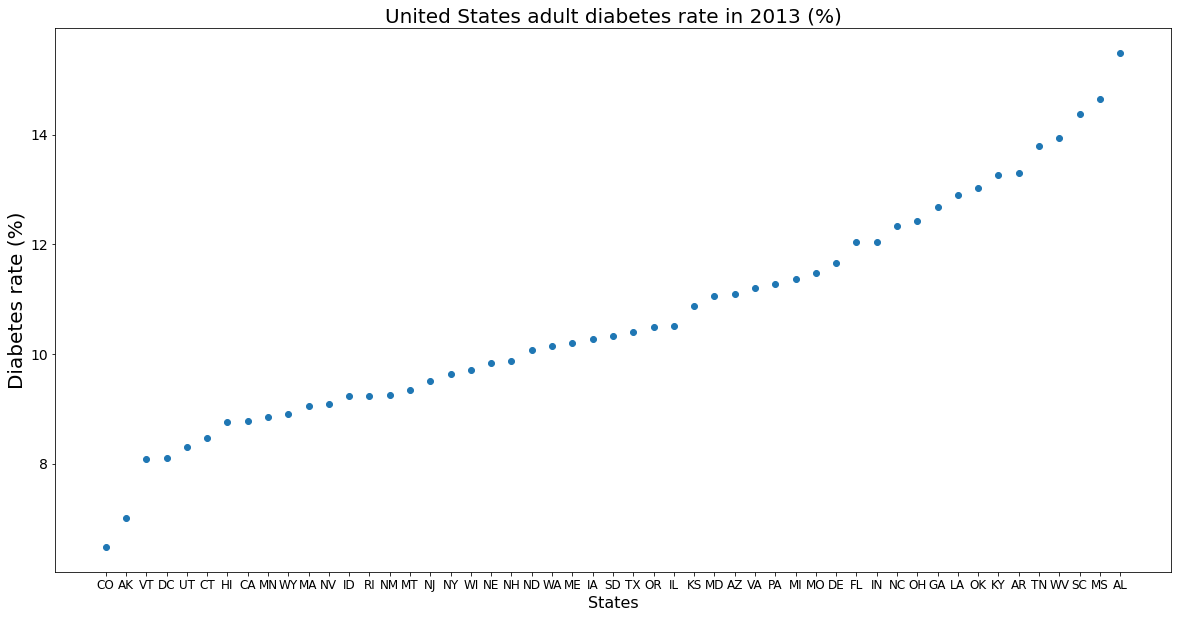

In [5]:
# Overview of adult diabetes rate by state
plt.figure(figsize=(20,10))
plt.plot(states.sort_values('PCT_DIABETES_ADULTS13')['PCT_DIABETES_ADULTS13'],'o')
plt.xlabel('States',fontsize=16)
plt.ylabel('Diabetes rate (%)',fontsize=20)
plt.title('United States adult diabetes rate in 2013 (%)',fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.show()

In [6]:
# Check for outliners in features based on state averages

# For loop to find outliers and convert them to NaN
outliers = {}
for column in states:
    data = states[column]
    mean = data.mean()
    std = data.std()
    # Define outliers and find their indexes
    outlier = data[(data > (mean+3*std))|(data < (mean-3*std))] # Alternatively: low,high = np.percentile(data,[1,99])
    slice_index = outlier.index # 
    # If there is no outlier in this column, go back to the beginning of the loop
    if slice_index.shape[0] == 0: continue   
    # Append outliers in a dictionary
    outliers[column]=states[column].loc[slice_index]
    
    # Convert outliers into NaN and remove from regression analysis later
    data[(data > (mean+3*std))|(data < (mean-3*std))] = np.NaN

len(outliers)

92

In [7]:
# check for missing values (outliers included as NaN)
states.isna().sum().sum()

153

In [8]:
## Regress each variable with the health variable 'PCT_DIABETES_ADULTS13' and put significant variables in a dictionary sig_var
# For exploratory purpose, thus p values not adjusted for multiple comparisons.
# Outliers and missing values at state level are removed from regression analysis. 

from scipy.stats import linregress

sig_var = {}
sig_r = {}

for column in states.drop('PCT_DIABETES_ADULTS13', axis=1):
    
    mask = ~np.isnan(states[column]) & ~np.isnan(states['PCT_DIABETES_ADULTS13']) # Mask Nan from regressions
    # Linear regression
    slope, intercept,rvalue, pvalue, stderr = linregress(states[column][mask], states['PCT_DIABETES_ADULTS13'][mask])
    
    # Return to the top of loop if not significant
    if pvalue >= 0.05: continue
    
    # Append significant variables to the dictionary      
    sig_var[column] = [slope, intercept, rvalue, pvalue, stderr]
    sig_r[column] = rvalue

In [9]:
# Sort dictionary
sorted_sig_r_tuples = sorted(sig_r.items(), key=lambda x:x[1]) # Output tuples

# If plot directly without using features' full names
import collections
sorted_sig_r = collections.OrderedDict(sorted_sig_r_tuples) # Convert to dict

In [14]:
len(sorted_sig_r_tuples)

67

In [14]:
# Read in the variables list 
variables=pd.read_csv('data_atlas/processed/variables.csv')
#Change column names
variables.columns=['Category','CategoryCode','SubName','VarName','VarCode','Selected','Geography','Unites']

# Update the detailed selected feature names in a new dict
varname = variables.loc[variables['VarCode'].isin(sorted_sig_r.keys()),['VarCode','VarName']]

# Combine detailed feature names
features = pd.DataFrame(sorted_sig_r_tuples)
features.columns = ['VarCode','r']
features = pd.merge(features,varname, on = 'VarCode') # Combine full feature names
features = features.set_index('VarName')

In [15]:
len(features)
features.to_csv('data_atlas/64features_010820.csv')

In [16]:
## 28 out of the 67 significantly correlated features are selected for regression analysis ##
## Based on interpretation of their relatedness to poverty and food environment
shortlist=['Full-service restaurants/1,000 pop, 2014',
 'Median household income, 2015',
 'Direct farm sales per capita, 2012',
 'Agritourism receipts, 2012',
 'Grocery stores/1,000 pop, 2014',         
 'Specialized food stores/1,000 pop, 2014',
 'Recreation & fitness facilities/1,000 pop, 2014',
 'Price of sodas/national average, 2010**',
 'Farms with direct sales (%), 2012',
 'Greenhouse vegetable and fresh herb farms, 2012',
 'Expenditures per capita, restaurants, 2012*',
 "Farmers' markets/1,000 pop, 2016",
 'CSA farms, 2012',
 'Population, low access to store (%), 2015',
 'Vegetable farms, 2012',
 'Farms with vegetables harvested for fresh market, 2012',

 'Price of low-fat milk/price of sodas, 2010**',
 'Convenience stores/1,000 pop, 2014',
 'Expenditures per capita, fast food, 2012*',
 'Household food insecurity (%, three-year average), 2013-15*',
 'National School Lunch Program participants (% pop), 2015*',
 'SNAP participants (% pop), 2016*',
 'Students eligible for free lunch (%), 2014',
 'Supercenters & club stores/1,000 pop, 2014',
 'School Breakfast Program participants (% pop), 2015*',
 'SNAP-authorized stores/1,000 pop, 2016',
 'Poverty rate, 2015',
 'Households, no car & low access to store (%), 2015',
 ]
# year ranges from 2010 to 2016

# Created shortened feature names simplifying plotting
Feature_names = ['Full-service restaurants/1,000 pop',
 'Median household income',
 'Direct farm sales per capita',
 'Agritourism receipts',
 'Grocery stores/1,000 pop',         
 'Specialized food stores/1,000 pop',
 'Recreation & fitness facilities/1,000 pop',
 'Price of sodas/national average',
 'Farms with direct sales (%)',
 'Greenhouse vegetable and fresh herb farms',
 'Expenditures per capita, restaurants',
 "Farmers' markets/1,000 pop",
 'CSA farms',
 'Population, low access to store (%)',
 'Vegetable farms',
 'Farms with vegetables harvested for fresh market',
 'Price of low-fat milk/price of sodas',
 'Convenience stores/1,000 pop',
 'Expenditures per capita, fast food',
 'Household food insecurity (%, three-year average)',
 'National School Lunch Program participants (% pop)',
 'SNAP participants (% pop)',
 'Students eligible for free lunch (%)',
 'Supercenters & club stores/1,000 pop',
 'School Breakfast Program participants (% pop)',
 'SNAP-authorized stores/1,000 pop',
 'Poverty rate, 2015',
 'Households, no car & low access to store (%)',
 ]

shortlist = pd.DataFrame({'VarName':shortlist,'ShortName':Feature_names})
shortlist = shortlist.set_index('VarName')

In [17]:
shortfeatures = features.join(shortlist,how='inner')

In [18]:
# Subset features dataframe 
shortfeatures.head()

,VarCode,r,ShortName
VarName,,,
"Full-service restaurants/1,000 pop, 2014",FSRPTH14,-0.699661,"Full-service restaurants/1,000 pop"
"Median household income, 2015",MEDHHINC15,-0.683195,Median household income
"Direct farm sales per capita, 2012",PC_DIRSALES12,-0.566868,Direct farm sales per capita
"Agritourism receipts, 2012",AGRITRSM_RCT12,-0.532238,Agritourism receipts
"Grocery stores/1,000 pop, 2014",GROCPTH14,-0.519540,"Grocery stores/1,000 pop"


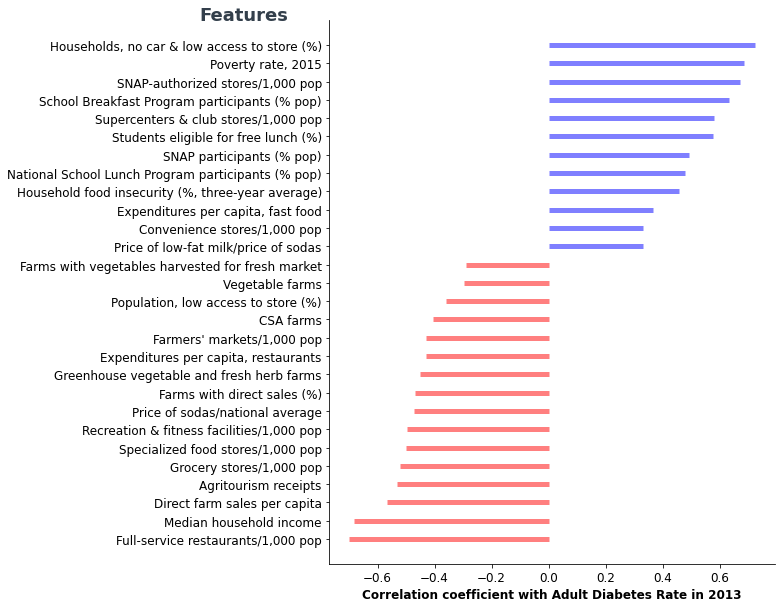

In [20]:
# Visualize significant features
# Reference: https://scentellegher.github.io/visualization/2018/10/10/beautiful-bar-plots-matplotlib.html

# A numeric placeholder for the y axis
my_range=list(range(1,len(shortfeatures.index)+1))

fig, ax = plt.subplots(figsize=(8,10))

colors = ['red']*16+['blue']*12 # create color lists for negative and positive correlated features

plt.hlines(y=my_range, xmin=0, xmax=shortfeatures['r'], color=colors, alpha=0.5, linewidth=5)

# set labels
ax.set_xlabel('Correlation coefficient with Adult Diabetes Rate in 2013', fontsize=12,fontweight='black')
#ax.set_ylabel('Features')

# # set axis
ax.tick_params(axis='both',which='major',labelsize=12)
#plt.yticks(my_range,shortfeatures['VarName'],fontsize=12)
plt.yticks(my_range,Feature_names,fontsize=12)

# # add an horizonal label for the y axis 
fig.text(-0.1, 0.88, 'Features', fontsize=18, fontweight='black', color = '#333F4B')

# Remove right and top borders
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

plt.savefig('Figs/shortlist_features.png', dpi=600,bbox_inches='tight')
plt.show()

#### 2.2 Dealing with missing values and outliers for County-level data


In [21]:
# Fill missing values using Iterative imputer
# which is a multivariate imputer that estimates each feature from all others
# Default estimator is BayesianRidge 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp_mean = IterativeImputer(min_value=0,random_state=0) # All values should be non negative

In [21]:
transformed = imp_mean.fit_transform(df.drop(['FIPS','State','County'],axis=1))

In [22]:
df_imp = pd.DataFrame(transformed)
df_imp.columns = df.drop(['FIPS','State','County'],axis=1).columns
df_imp = pd.concat([df.loc[:,['FIPS','State','County']],df_imp],axis=1)
df_imp.to_csv('data_atlas/processed/transformed.csv') # Save results to file
df_imp = pd.read_csv('data_atlas/processed/transformed.csv',index_col=0)

In [23]:
df_imp.head()

,FIPS,State,County,PCT_SNAP16,FOODHUB16,PCT_FMRKT_BAKED16,PCT_FMRKT_WICCASH16,FMRKT_ANMLPROD16,FMRKT_BAKED16,FMRKT_OTHERFOOD16,...,PCT_NHBLACK10,PCT_NHWHITE10,PCH_SBP_09_15,PCH_CACFP_09_15,PCH_WIC_09_15,PCH_SFSP_09_15,PCH_NSLP_09_15,FOODINSEC_CHILD_03_11,CH_FOODINSEC_12_15,CH_VLFOODSEC_12_15
0,1001,AL,Autauga,16.976436,0.0,100.0,0.0,0.0,1.0,1.0,...,17.582599,77.246156,0.723991,0.139507,-0.271065,0.462219,-1.380526,9.3,-0.3,0.5
1,1003,AL,Baldwin,16.976436,0.0,75.0,0.0,4.0,3.0,3.0,...,9.308425,83.504787,0.723991,0.139507,-0.271065,0.462219,-1.380526,9.3,-0.3,0.5
2,1005,AL,Barbour,16.976436,0.0,50.0,0.0,0.0,2.0,2.0,...,46.691190,46.753105,0.723991,0.139507,-0.271065,0.462219,-1.380526,9.3,-0.3,0.5
3,1007,AL,Bibb,16.976436,0.0,0.0,0.0,0.0,0.0,0.0,...,21.924504,75.020729,0.723991,0.139507,-0.271065,0.462219,-1.380526,9.3,-0.3,0.5
4,1009,AL,Blount,16.976436,0.0,100.0,0.0,1.0,1.0,1.0,...,1.263040,88.887338,0.723991,0.139507,-0.271065,0.462219,-1.380526,9.3,-0.3,0.5


In [24]:
# Check examples of imputed missing values for DC
df_imp.loc[df_imp['State']=='DC',['FRESHVEG_ACRES12','GHVEG_FARMS12']]
# It sounds reasonable to predict that DC has 0 fresh vegetable acres for fresh market 
# and around 10 greenhouse vegetable farms, since it is a metro aera.

,FRESHVEG_ACRES12,GHVEG_FARMS12
319,0.0,10.404155


In [28]:
# Winsorization of outliers 
from scipy.stats.mstats import winsorize

df_winsorized = df_imp.copy()
for column in df_winsorized.iloc[:,3:]:
    df_winsorized[column]=winsorize(df_winsorized[column],limits=[0.05,0.05])
df_winsorized.to_csv('data_atlas/processed/winsorized.csv')

In [29]:
df_winsorized = pd.read_csv('data_atlas/processed/winsorized.csv',index_col=0)

In [30]:
df_winsorized.head()

,FIPS,State,County,PCT_SNAP16,FOODHUB16,PCT_FMRKT_BAKED16,PCT_FMRKT_WICCASH16,FMRKT_ANMLPROD16,FMRKT_BAKED16,FMRKT_OTHERFOOD16,...,PCT_NHBLACK10,PCT_NHWHITE10,PCH_SBP_09_15,PCH_CACFP_09_15,PCH_WIC_09_15,PCH_SFSP_09_15,PCH_NSLP_09_15,FOODINSEC_CHILD_03_11,CH_FOODINSEC_12_15,CH_VLFOODSEC_12_15
0,1001,AL,Autauga,16.976436,0.0,100.0,0.0,0.0,1.0,1.0,...,17.582599,77.246156,0.723991,0.139507,-0.271065,0.462219,-1.380526,9.3,-0.3,0.5
1,1003,AL,Baldwin,16.976436,0.0,75.0,0.0,4.0,3.0,3.0,...,9.308425,83.504787,0.723991,0.139507,-0.271065,0.462219,-1.380526,9.3,-0.3,0.5
2,1005,AL,Barbour,16.976436,0.0,50.0,0.0,0.0,2.0,2.0,...,41.811490,46.753105,0.723991,0.139507,-0.271065,0.462219,-1.380526,9.3,-0.3,0.5
3,1007,AL,Bibb,16.976436,0.0,0.0,0.0,0.0,0.0,0.0,...,21.924504,75.020729,0.723991,0.139507,-0.271065,0.462219,-1.380526,9.3,-0.3,0.5
4,1009,AL,Blount,16.976436,0.0,100.0,0.0,1.0,1.0,1.0,...,1.263040,88.887338,0.723991,0.139507,-0.271065,0.462219,-1.380526,9.3,-0.3,0.5


In [31]:
shortfeatures

,VarCode,r,ShortName
VarName,,,
"Full-service restaurants/1,000 pop, 2014",FSRPTH14,-0.699661,"Full-service restaurants/1,000 pop"
"Median household income, 2015",MEDHHINC15,-0.683195,Median household income
"Direct farm sales per capita, 2012",PC_DIRSALES12,-0.566868,Direct farm sales per capita
"Agritourism receipts, 2012",AGRITRSM_RCT12,-0.532238,Agritourism receipts
"Grocery stores/1,000 pop, 2014",GROCPTH14,-0.519540,"Grocery stores/1,000 pop"
"Specialized food stores/1,000 pop, 2014",SPECSPTH14,-0.500029,"Specialized food stores/1,000 pop"
"Recreation & fitness facilities/1,000 pop, 2014",RECFACPTH14,-0.494998,"Recreation & fitness facilities/1,000 pop"
"Price of sodas/national average, 2010**",SODA_PRICE10,-0.471260,Price of sodas/national average
"Farms with direct sales (%), 2012",PCT_LOCLFARM12,-0.467109,Farms with direct sales (%)


In [53]:
# Select a few features for visualization
test = df_winsorized[['FIPS','POVRATE15','MILK_SODA_PRICE10','FSRPTH14','RECFACPTH14']].set_index('FIPS')
test.columns = ['Poverty Rate','Milk/Soda price ratio','Full service restaurants/1000 pop','Recreation facilities/1000 pop']
test2 = pd.DataFrame(test.unstack().reset_index())
test2.columns=['Features','FIPS','Values']
test2.head()

,Features,FIPS,Values
0,Poverty Rate,1001,12.7
1,Poverty Rate,1003,12.9
2,Poverty Rate,1005,28.1
3,Poverty Rate,1007,22.2
4,Poverty Rate,1009,14.7


In [54]:
df_long = pd.merge(test2,df[['FIPS','PCT_DIABETES_ADULTS13']], on='FIPS')
df_long.columns = ['Features','FIPS','Values','Adult Diabetes Rate']

In [55]:
df_long.head()

,Features,FIPS,Values,Adult Diabetes Rate
0,Poverty Rate,1001,12.700000,13.0
1,Milk/Soda price ratio,1001,0.923289,13.0
2,Full service restaurants/1000 pop,1001,0.523513,13.0
3,Recreation facilities/1000 pop,1001,0.090261,13.0
4,Poverty Rate,1003,12.900000,10.4


<Figure size 864x864 with 0 Axes>

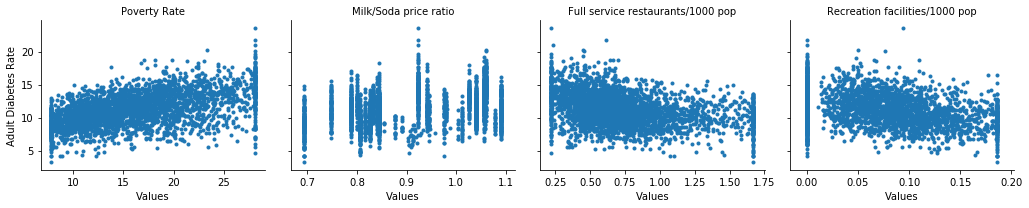

In [56]:
# Visualize a few representive features' correlation with diabetes rates
plt.figure(figsize=(12,12))
g = sns.FacetGrid(df_long,col='Features',col_wrap=4, height=3,aspect=1.2, sharex=False,)
g = g.map(plt.scatter,'Values','Adult Diabetes Rate',marker='.' ).set_titles("{col_name}")


# 3. Statistical analysis

### Mean comparisons using Student's t-test

**Null hypothesis 1**: Metro and non-metro counties have same means for adult diabetes rate in 2013  
**Null hypothesis 2**: Poverty and non-poverty counties have same means for adult diabetes rate in 2013

In [90]:
socio = pd.read_excel("data_atlas/atlas.xlsx", sheet_name= "SOCIOECONOMIC")
socio = socio.set_index('FIPS')
metro_info = pd.DataFrame(socio['METRO13'])
metro_info = metro_info.reset_index()

# Add metro info to dataframe
# Note here we use the original data rather than winsorized data, since the extreme diabetes rates in some counties are unlikely random mistakes
# Using winsorized data did not change the significance and conclusions of the results.
df2 = pd.concat([df,metro_info['METRO13']],axis=1) 

In [91]:
# Slice dataframe into Metro and non-metro counties 
metro = df2.loc[df2['METRO13']== 1,:]
nonmetro = df2.loc[df2['METRO13']== 0,:]
print('There are {} metro and {} non-metro counties.'.format(metro.shape[0],nonmetro.shape[0]))

There are 1167 metro and 1976 non-metro counties.


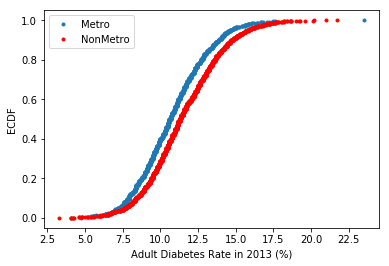

<Figure size 432x288 with 0 Axes>

In [62]:
# Visualization
# Plot the Empirical cumulative distribution of diabetes rates for metro and nonmetro counties

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements"""
    n =len(data)
    x = np.sort(data)
    y = np.arange(1,n+1)/n
    return x,y

x_metro, y_metro = ecdf(metro['PCT_DIABETES_ADULTS13'])
x_nonmetro, y_nonmetro = ecdf(nonmetro['PCT_DIABETES_ADULTS13'])

plt.plot(x_metro,y_metro,marker='.',linestyle='none',label='Metro')
plt.plot(x_nonmetro,y_nonmetro,marker='.',linestyle='none', color = 'red',label='NonMetro')
plt.xlabel('Adult Diabetes Rate in 2013 (%)')
plt.ylabel('ECDF')
plt.legend()
plt.show()

plt.savefig('Figs/metro_nonmetro_ecdf.png')

In [63]:
# t-test, assuming equal variances of the two groups
t1,p1 = stats.ttest_ind(metro['PCT_DIABETES_ADULTS13'],nonmetro['PCT_DIABETES_ADULTS13'],
                        nan_policy='omit')
print('p value:',round(p1,2))

p value: 0.0


#### Because p=0, we can reject null hypothesis 1 and conclude that there are significant differences in diabetes rate between metro and non-metro counties. Non-metro counties has higher diabetes rate. 
#### Next, let's examine persistant-poverty counties vs. non-poverty counties

In [64]:
# Add poverty county info to dataframe
df2 = pd.concat([df2,socio['PERPOV10'].reset_index()],axis=1)

# slice dataframe into poverty-persistant counties and non-poverty counties
ppov = df2.loc[df2['PERPOV10']== 1,:]
nonppov = df2.loc[df2['PERPOV10']== 0,:]
print('There are {} ppov and {} non-ppov counties.'.format(ppov.shape[0],nonppov.shape[0]))

There are 353 ppov and 2790 non-ppov counties.


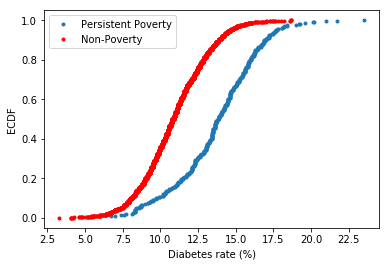

<Figure size 432x288 with 0 Axes>

In [65]:
x_ppov, y_ppov = ecdf(ppov['PCT_DIABETES_ADULTS13'])
x_nonppov, y_nonppov = ecdf(nonppov['PCT_DIABETES_ADULTS13'])

plt.plot(x_ppov, y_ppov,marker='.',linestyle='none',label='Persistent Poverty')
plt.plot(x_nonppov, y_nonppov,marker='.',linestyle='none', color = 'red',label='Non-Poverty')
plt.xlabel('Diabetes rate (%)')
plt.ylabel('ECDF')
plt.legend()
plt.show()

plt.savefig('Figs/ppov_nonppov_ecdf.png')

In [66]:
# Because the size of two groups are very different and likely have different variance, 
# we will perform Weltch's t-test by setting equal_var=False

t2,p2 = stats.ttest_ind(ppov['PCT_DIABETES_ADULTS13'],nonppov['PCT_DIABETES_ADULTS13'].dropna(),equal_var=False)
print('p value:',round(p2,2))

p value: 0.0


#### Because p=0, we can reject our hypothesis and conclude that the diabetes rate in non-poverty counties is significantly different (smaller than) persistent poverty counties.

In [67]:
pd.crosstab(df2['PERPOV10'],df2['METRO13'])

METRO13,0,1
PERPOV10,,
0,1675,1115
1,301,52


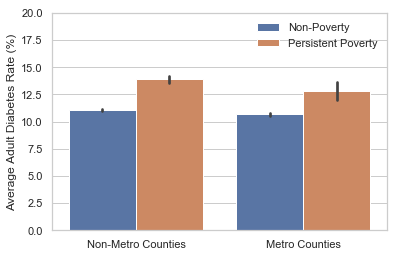

In [68]:
# Visualize average diabetes rates across the groups
sns.set(style="whitegrid")
ax = sns.barplot(x='METRO13',y='PCT_DIABETES_ADULTS13',hue='PERPOV10',data=df2) # showing standard error bars
ax.set_xticklabels(['Non-Metro Counties','Metro Counties'])
labels = ['Non-Poverty','Persistent Poverty']
h, l = ax.get_legend_handles_labels()
ax.legend(h,labels,frameon=False)

_ = plt.ylim(0,20)
_ = plt.ylabel('Average Adult Diabetes Rate (%)')
_ = plt.xlabel('')


plt.savefig('Figs/Avg_diabetes.png',dpi=600)


# 4. Predicting Diabetes--Supervised learning models
## 4.1 Linear regression

In [32]:
from sklearn.model_selection import train_test_split
# Slice cleaned dataframe with only 28 features
df_short = df_winsorized.loc[:, shortfeatures['VarCode'].tolist()]
df_short.shape

# Drop some highly correlated features after viewing the correlation matrix
df_short2 = df_short.drop(['MEDHHINC15','FRESHVEG_FARMS12','VEG_FARMS12','PCT_NSLP15',
                     'PCT_FREE_LUNCH14','PCT_LACCESS_HHNV15',
                    'PCT_LOCLFARM12','GHVEG_FARMS12','PCT_SBP15','SNAPSPTH16',
                    'AGRITRSM_RCT12','PC_FFRSALES12','PC_DIRSALES12'],axis=1)

X = df_short2 # predictive features 
y = df_winsorized.PCT_DIABETES_ADULTS13 # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=5)

In [33]:
# Check if any two features are highly correlated
corr =df_short.corr() # Correlation matrix

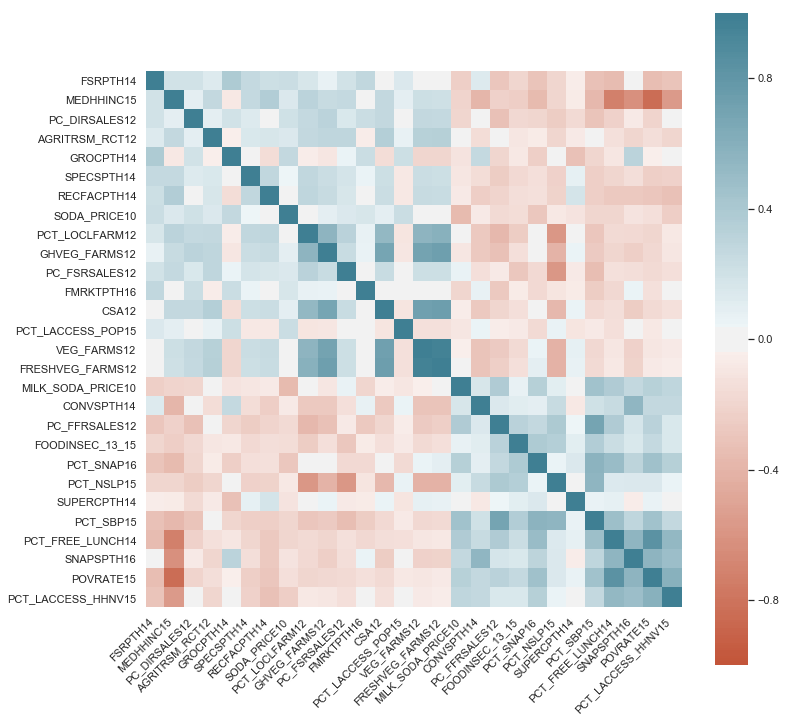

In [71]:
# Visualize correlation matrix
plt.figure(figsize=(12,12))
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20,220,n=200),
    square=True)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right')

plt.show()

Some features are heavily correlated with each other and are removed from the analysis, resulting in 15 shortlist features

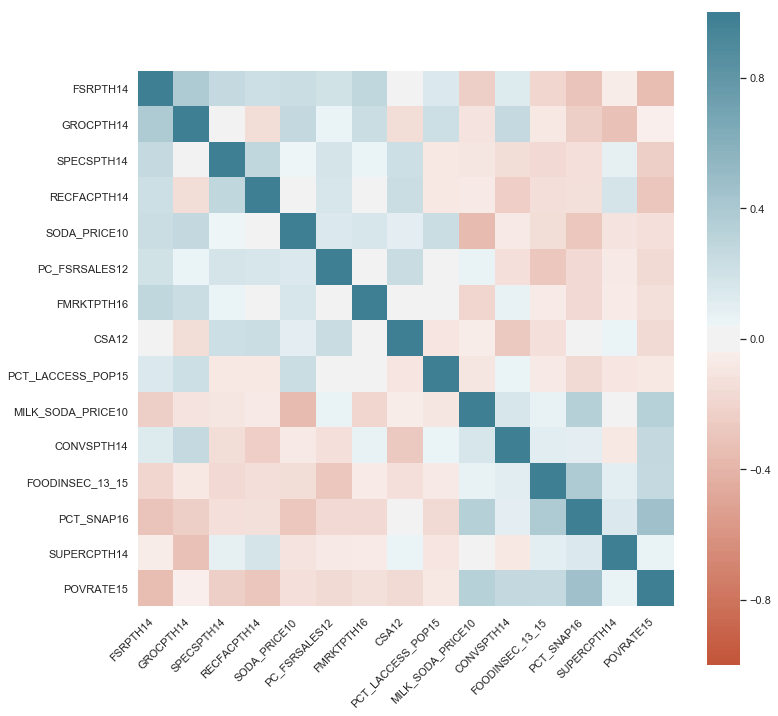

In [72]:
# Visualize correlation matrix with the reduced suite of features (15 total)
corr2 =df_short.drop(['MEDHHINC15','FRESHVEG_FARMS12','VEG_FARMS12','PCT_NSLP15',
                     'PCT_FREE_LUNCH14','PCT_LACCESS_HHNV15',
                    'PCT_LOCLFARM12','GHVEG_FARMS12','PCT_SBP15','SNAPSPTH16',
                    'AGRITRSM_RCT12','PC_FFRSALES12','PC_DIRSALES12'],axis=1).corr() # Correlation matrix

plt.figure(figsize=(12,12))
ax = sns.heatmap(
    corr2,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20,220,n=200),
    square=True)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right')

#plt.show()
plt.savefig('Figs/correlation_matrix_15features.png',dpi=600)

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

scaler=StandardScaler()
m1 = LinearRegression()
pipeline = make_pipeline(scaler,m1)

# Fit model with training data
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [74]:
scaled = scaler.fit_transform(X_train)

In [75]:
print('R-squared of training data:',pipeline.score(X_train,y_train))
print('R-squared of test data:',pipeline.score(X_test,y_test))

R-squared of training data: 0.513292245344822
R-squared of test data: 0.5598076477730354


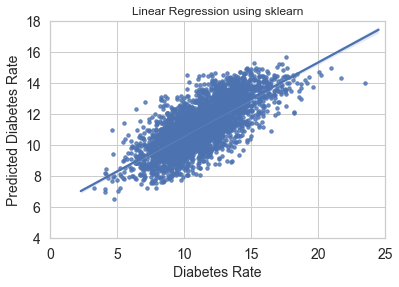

<Figure size 432x288 with 0 Axes>

In [76]:
##### Visualize fitted values by sklearn
# Plot with original diabeted data
sns.regplot(x=df.PCT_DIABETES_ADULTS13,y=pipeline.predict(X),scatter_kws={'s':12})
plt.xlabel('Diabetes Rate',fontsize=14)
plt.ylabel('Predicted Diabetes Rate',fontsize=14)
plt.xlim(0,25)
plt.ylim(4,18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Linear Regression using sklearn')
plt.show()
plt.savefig('Figs/MLR.png')

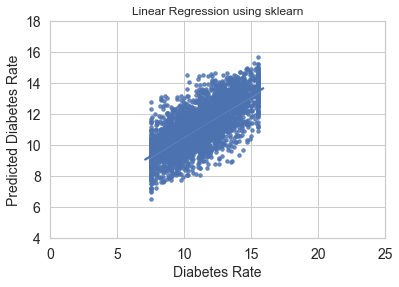

In [77]:
# Plot with winsorized diabetes data
sns.regplot(x=df_winsorized.PCT_DIABETES_ADULTS13,y=pipeline.predict(X),scatter_kws={'s':12})
plt.xlabel('Diabetes Rate',fontsize=14)
plt.ylabel('Predicted Diabetes Rate',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0,25)
plt.ylim(4,18)
plt.title('Linear Regression using sklearn')
plt.show()

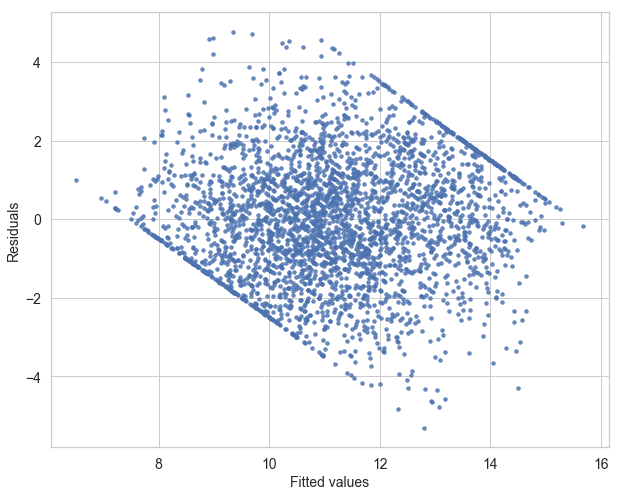

In [78]:
# Check model assumptions
# 1) Fitted value vs. residuals plot
plt.figure(figsize=(10,8))
resid = y - pipeline.predict(X)
_ = sns.regplot(x=pipeline.predict(X),y=resid,fit_reg=False,scatter_kws={'s':12})
_ = plt.xlabel('Fitted values',fontsize=14)
_ = plt.ylabel('Residuals',fontsize=14)
_ = plt.xticks(fontsize=14)
_ = plt.yticks(fontsize=14)
plt.savefig('Figs/homoscedasticity_m1.png',)

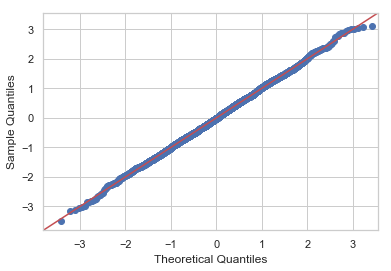

In [79]:
# 2): Quantile plot of the residuals
import statsmodels.api as sm
fig = sm.qqplot(resid, stats.t, fit=True, line='45')
plt.savefig('Figs/qqplot_m1.png')

In [80]:
# Get the coefficients
coefs = pd.DataFrame({'VarCode': X.columns, 'estimatedCoefficients': m1.coef_})[['VarCode', 'estimatedCoefficients']]
coefs = coefs.sort_values(by='estimatedCoefficients')
coefs.head()

,VarCode,estimatedCoefficients
5,PC_FSRSALES12,-0.350372
4,SODA_PRICE10,-0.307248
7,CSA12,-0.283506
3,RECFACPTH14,-0.219168
0,FSRPTH14,-0.215002


**Summary:** after checking for correlations among features and coeffients from initial regression, we removed 13 features and used 15 features for the final linear regression model. This resulted an R2= 0.51 for the training dataset and an R2= 0.56 for the testing dataset. Model assumptions on the homoscedasticity and normality of residuals were confirmed as well.  
The model may be underfitting, thus we shall look at more complex models such as Trees.

## 4.2 Decision Trees

In [35]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score

In [82]:
# %load functions/models.py
# This file contains functions for modeling diabetes rate across U.S. counties
import warnings
warnings.filterwarnings('ignore')

def gridsearch_models(X, y, regressor,params):
    '''Conduct GridsearchCV to find best parameters, and
     fit the model with best parameters'''

    # Split data into train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=5)
    
    # GridsearchCV
    fitted = regressor.fit(X_train, y_train)
    model = GridSearchCV(fitted,params)
    model.fit(X_train, y_train)
    best_params = model.best_estimator_.get_params()
    print('Best parameters:', best_params) # print best parameters

    # Fit model with best params
    regressor.set_params(**best_params) # update model parameters
    best_model= regressor.fit(X_train,y_train)
    print('Cross validation scores:',cross_val_score(model, X_train, y_train)) # print cross validation scores

    # Print model score (e.g.,R-squared) for train and test data set
    print('Training data R-squared for best model:', round(model.score(X_train, y_train),2))
    print('Testing data R-squared for best model:', round(model.score(X_test, y_test),2))

    return best_model


In [42]:
tree = DecisionTreeRegressor(random_state=5)
max_depth = [3,4,5]
min_samples_split = list(range(10,51,10))
min_samples_leaf = list(range(1,21,1))
max_features = [3,4,5,6,7,8,9,10,11,12]

params = {'max_depth':max_depth,
             'min_samples_split':min_samples_split,
             'min_samples_leaf':min_samples_leaf,
             'max_features':max_features}
best_tree = gridsearch_models(X,y, tree, params)

{'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 5, 'max_features': 12, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 40, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': 5, 'splitter': 'best'}
[0.55794995 0.48804596 0.45640839 0.39087743 0.52395964]
Training data R-squared: 0.5831884979699005
Testing data R-squared: 0.5483922134921324


In [46]:
from sklearn.tree import export_graphviz
export_graphviz(best_tree, out_file='tree_gridsearch.dot',
               feature_names = X.columns)

In [47]:
from subprocess import call

call(['dot', '-T', 'png', 'Figs/tree_gridsearch.dot', '-o', 'Figs/tree_gridsearch.png'])

2

 <img src="Figs/tree_gridsearch.png">

**Summary:** After tuning hyperparameters and cross validation, our best decision tree obtained an R2= 0.58 for the training dataset and an R2= 0.55 for the testing dataset. The model is slightly overfitting.  
Thus we shall try Random Forest next to control for overfitting and improve model accuracy.
  
According to the this tree, the most important feature (root node) is **restaurant expenditures per capita** (PC_FSRSALES12). Features for the 2nd and 3rd splits include:
 - Price of low-fat milk/price of sodas (MILK_SODA_PRICE10)
 - Poverty rate (POVRATE15)
 - Specialized food stores/1,000 pop (SPECSPTH)
 - Food insecurity, three year average (FOODINSEC)
 - Recreation & fitness facilities/1,000 pop (RECFACPTH14)

## 4.3 Random Forest

In [49]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=21) # regressor

In [83]:
# Parameters
n_estimators = [60, 80, 100]
max_depth = [4,5]
min_samples_split = list(range(5,56,10))
min_samples_leaf = [2,5,10]
max_features = ['auto','sqrt']

params = {'n_estimators':n_estimators,
             'max_depth':max_depth,
             'min_samples_split':min_samples_split,
             'min_samples_leaf':min_samples_leaf,
             'max_features':max_features}

# Gridsearch and fitting with optimized parameters
rf_best = gridsearch_models(X, y, rf, params)


Best parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 80, 'n_jobs': None, 'oob_score': False, 'random_state': 21, 'verbose': 0, 'warm_start': False}
Cross validation scores: [0.63850698 0.5960331  0.61300203 0.54467079 0.60328599]
Training data R-squared for best model: 0.68
Testing data R-squared for best model: 0.63


In [84]:
# Rank importance of features
importance =pd.DataFrame({'VarCode':X.columns, 
                          'Importance':rf_best.feature_importances_}).sort_values(by=['Importance'],ascending=False)
importance = importance.set_index('VarCode')

In [85]:
importance = importance.join(shortfeatures.set_index('VarCode'))
importance.head()

,Importance,r,ShortName
VarCode,,,
PCT_SNAP16,0.290175,0.477796,SNAP participants (% pop)
POVRATE15,0.203081,0.683069,"Poverty rate, 2015"
PC_FSRSALES12,0.156427,-0.431063,"Expenditures per capita, restaurants"
CONVSPTH14,0.068044,0.331765,"Convenience stores/1,000 pop"
FOODINSEC_13_15,0.061752,0.455828,"Household food insecurity (%, three-year average)"


In [ ]:
# %load functions/barplot.py
def barplot(data, title):
    '''Function to make customized bar plot'''
    figure = sns.barplot(y='ShortName', x='Importance', data=data)
    plt.ylabel('Features')
    plt.xlim(0, 0.5)
    plt.title('Feature importance for {}'.format(title))
    plt.show()

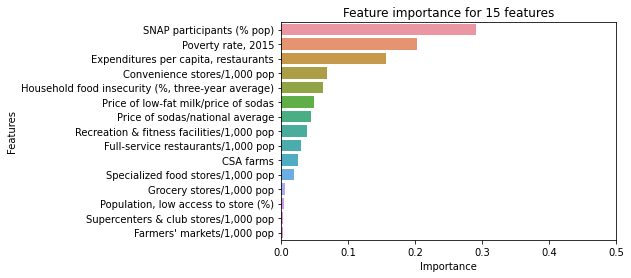

In [109]:
barplot(data=importance, title='15 features')

**Summary:** 
After tuning hyperparameters and cross validation, our best random forest model obtained an R2= 0.68 for the training dataset and an R2= 0.63 for the testing dataset. The model accuracy improved comparing to linear regression and a single decision tree. It may be slightly overfitting.



### Random forest for Metro and Non-Metro counties, respectively

In [92]:
# Create metro and non-metro data frames for the shortlist features 
df3 = pd.concat([df_winsorized, metro_info['METRO13'],socio['PERPOV10'].reset_index()],axis=1) 

X2 = pd.concat([df_short2,df['FIPS']],axis=1) # df_short2 contains the shortlist features from the winsorized data.
X2 = pd.concat([X2,metro_info['METRO13'],socio['PERPOV10'].reset_index()], axis=1)

ymetro = df3.loc[df3['METRO13']== 1,'PCT_DIABETES_ADULTS13']
ynonmetro = df3.loc[df3['METRO13']== 0,'PCT_DIABETES_ADULTS13']
ypov = df3.loc[df3['PERPOV10']== 1,'PCT_DIABETES_ADULTS13']
ynonpov = df3.loc[df3['PERPOV10']== 0,'PCT_DIABETES_ADULTS13']

In [93]:
# Split data into training and testing sets
# For metro and non-metro counties
Xmetro = X2.loc[X2['METRO13']==1,:].drop(['METRO13','PERPOV10','FIPS'], axis=1)
Xnonmetro = X2.loc[X2['METRO13']==0,:].drop(['METRO13','PERPOV10','FIPS'], axis=1)

# For poverty and non-poverty counties
Xpov = X2.loc[X2['PERPOV10']==1,:].drop(['METRO13','PERPOV10','FIPS'], axis=1)
Xnonpov = X2.loc[X2['PERPOV10']==0,:].drop(['METRO13','PERPOV10','FIPS'], axis=1)

In [95]:
#Parameter tuning and gridsearch for Metro and non-metro counties
n_estimators = [100, 120, 140]
max_depth = [3,4]
min_samples_split = list(range(5,26,5))
min_samples_leaf = [2,5,10]
max_features = ['auto','sqrt']

params = {'n_estimators':n_estimators,
             'max_depth':max_depth,
             'min_samples_split':min_samples_split,
             'min_samples_leaf':min_samples_leaf,
             'max_features':max_features}

print('Metro counties: \n')
rf_metro = gridsearch_models(Xmetro,ymetro,rf,params)

print('\nNon-Metro counties: \n')
rf_nonmetro = gridsearch_models(Xnonmetro,ynonmetro,rf,params)

Metro counties: 

Best parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 5, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 120, 'n_jobs': None, 'oob_score': False, 'random_state': 21, 'verbose': 0, 'warm_start': False}
Cross validation scores: [0.50291807 0.5474173  0.5862755  0.5762814  0.5062979 ]
Training data R-squared for best model: 0.67
Testing data R-squared for best model: 0.57

Non-Metro counties: 

Best parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 140, 'n_jobs': None, 'oob_score': False, 'random_state': 21, 'v

In [98]:
# #Parameter tuning and gridsearch for Pov and non-pov counties
n_estimators = [60, 80, 100]
max_depth = [3,4]
min_samples_split = list(range(5,26,5))
min_samples_leaf = [2,4,6,8]
max_features = ['auto','sqrt']

params = {'n_estimators':n_estimators,
             'max_depth':max_depth,
             'min_samples_split':min_samples_split,
             'min_samples_leaf':min_samples_leaf,
             'max_features':max_features}
print('Poverty-persistent counties: \n')
rf_pov = gridsearch_models(Xpov,ypov,rf,params)
print('\nNon-Poverty persistent counties: \n')
rf_nonpov = gridsearch_models(Xnonpov,ynonpov,rf,params)

Poverty-persistent counties: 

Best parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 60, 'n_jobs': None, 'oob_score': False, 'random_state': 21, 'verbose': 0, 'warm_start': False}
Cross validation scores: [0.45936752 0.59336297 0.57984898 0.58632733 0.56940234]
Training data R-squared for best model: 0.72
Testing data R-squared for best model: 0.47

Non-Poverty persistent counties: 

Best parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 80, 'n_jobs': None, 'oob_score': False,

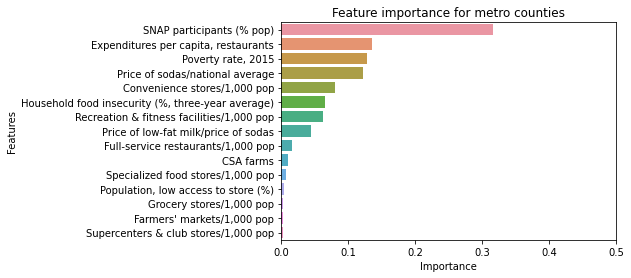

In [114]:
# Rank importance of features for Metro counties
importance_metro =pd.DataFrame({'VarCode':X2.drop(['METRO13','PERPOV10','FIPS'],axis=1).columns, 'Importance':rf_metro.feature_importances_}).sort_values(by=['Importance'],ascending=False)
importance_metro = importance_metro.set_index('VarCode')
importance_metro
importance_metro = importance_metro.join(shortfeatures.set_index('VarCode'))
importance.head()

barplot(importance_metro, 'metro counties')

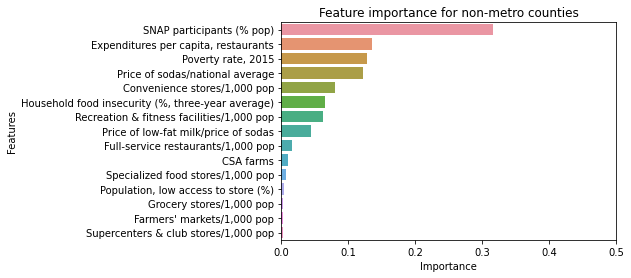

In [115]:
# Rank importance of features for Non-Metro counties
importance_nonmetro =pd.DataFrame({'VarCode':X2.drop(['METRO13','PERPOV10','FIPS'],axis=1).columns, 
                                   'Importance':rf_nonmetro.feature_importances_}).sort_values(by=['Importance'],ascending=False)
importance_nonmetro = importance_nonmetro.set_index('VarCode')
importance_nonmetro
importance_nonmetro = importance_nonmetro.join(shortfeatures.set_index('VarCode'))
importance_nonmetro.head()

barplot(importance_nonmetro, 'non-metro counties')

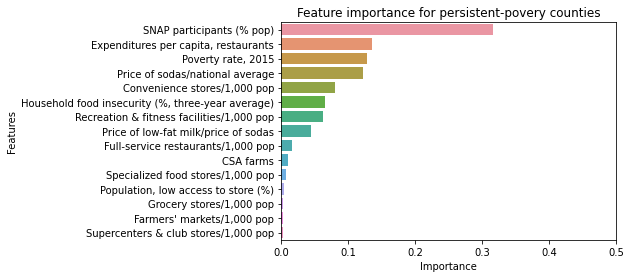

In [116]:
# Rank importance of features for poverty counties
importance_pov =pd.DataFrame({'VarCode':X2.drop(['METRO13','PERPOV10','FIPS'],axis=1).columns, 'Importance':rf_pov.feature_importances_}).sort_values(by=['Importance'],ascending=False)
importance_nonpov =pd.DataFrame({'VarCode':X2.drop(['METRO13','PERPOV10','FIPS'],axis=1).columns, 'Importance':rf_nonpov.feature_importances_}).sort_values(by=['Importance'],ascending=False)

                                
importance_pov = importance_pov.set_index('VarCode')
importance_pov = importance_pov.join(shortfeatures.set_index('VarCode'))
importance_nonpov = importance_nonpov.set_index('VarCode')
importance_nonpov = importance_nonpov.join(shortfeatures.set_index('VarCode'))

barplot(importance_pov, 'persistent-povery counties')

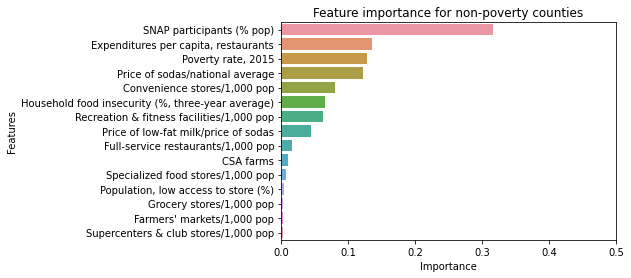

In [117]:
barplot(importance_nonpov, 'non-poverty counties')

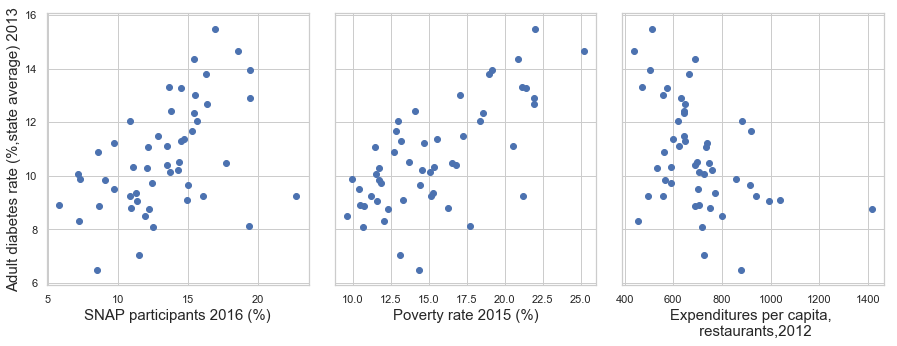

In [98]:
# Correlations between top features and diabetes rate
fig,(ax1,ax2,ax3) = plt.subplots(1,3, sharey=True, figsize=(15,5),
                                gridspec_kw={'hspace': 0, 'wspace': 0.1})
# Set figure title
#fig.suptitle('xyz')
                    
ax1.scatter(states.PCT_SNAP16,states.PCT_DIABETES_ADULTS13)
ax2.scatter(states.POVRATE15,states.PCT_DIABETES_ADULTS13)
ax3.scatter(states.PC_FSRSALES12,states.PCT_DIABETES_ADULTS13)

ax1.set_ylabel('Adult diabetes rate (%,state average) 2013',fontsize=15)
ax1.set_xlabel('SNAP participants 2016 (%)',fontsize=15)
ax2.set_xlabel('Poverty rate 2015 (%)',fontsize=15)
ax3.set_xlabel('Expenditures per capita, \n restaurants,2012',fontsize=15)

# If need to rotate tick labels
ax2.tick_params(axis='x', rotation=0)
ax3.tick_params(axis='x', rotation=0)

fig.savefig('Figs/top3features_diabetes.png',dpi=600,bbox_inches='tight')

**Summary**   
Based on random forest model results, when considering all counties, features related to economic status generally played the most important role in predicting diabetes rate. The top ranked features included SNAP participants, poverty rate and expenditures at restaurants. After dividing counties according to urbanity, SNAP participants remained the most important feature for both metro and non-metro groups. However, for metro counties the number of convenience stores/1000 population became the 2nd place (up from 4th), while for non-metro counties the price of low-fat milk/price of sodas became the 2nd place (up from 7th). These features are all positively correlated with diabetes rate.  
  
For non-persistent poverty counties, SNAP participants, Expenditures per capita at restaurants and poverty rate are also top features predictive of diabetes rate. In contrast, among persistent-poverty counties the expenditures at restaurants became the most predictive feature, followed by household food insecurity and SNAP participants. It is possible that when comparing counties of similar poverty level (i.e., non-persistent poverty or persistent poverty), habits/cultures related to dining-out spending may be associated with people’s fitness.

## 4.4 XGBoost

In [119]:
from xgboost import XGBRegressor
m_xgb = XGBRegressor(seed=1,silent=1)

#### XGBoost parameter tuning 

In [120]:
# Ref: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
params = {
    'max_depth': range(3,6,1),
    
    #Defines the minimum sum of weights of all observations required in a child.
    'min_child_weight': range(3,6,1),
    
    # Gamma specifies the minimum loss reduction required to make a split. Default 0
    'gamma':[i/10.0 for i in range(0,5)],

# 'subsample': Same as the subsample of GBM. Denotes the fraction of observations to be randomly samples for each tree.
# Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting.
#Typical values: 0.5-1
    'subsample': [i / 10.0 for i in range(6, 10)],

## 'colsample_bytree': Similar to max_features in GBM. Denotes the fraction of columns to be randomly samples for each tree.
# Typical values: 0.5-1
    'colsample_bytree': [i / 10.0 for i in range(5, 7)],

     'reg_alpha':[1e-2,0,0.1,1],
     'reg_lambda' : [1, 2, 3,]
}


best_xgb = gridsearch_models(X,y,m_xgb,params)

Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.6, 'gamma': 0.3, 'importance_type': 'gain', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 5, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 1, 'silent': 1, 'subsample': 0.9, 'verbosity': 1}
Cross validation scores: [0.66939263 0.63423864 0.67981605 0.6115324  0.68016101]
Training data R-squared for best model: 0.83
Testing data R-squared for best model: 0.69


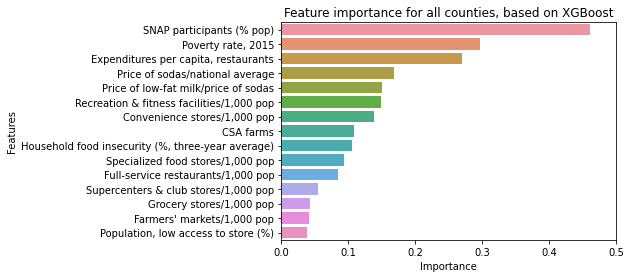

In [134]:
# Obtain feature importance
xgb_dict = best_xgb.get_booster().get_score(importance_type='gain')

# Rank importance of features
importance =pd.DataFrame.from_dict(xgb_dict,orient='index')
importance.columns = ['Importance']
importance = importance.join(shortfeatures.set_index('VarCode'))
importance = importance.sort_values(by='Importance',ascending=False)
importance['Importance']= importance['Importance']/150 # Scale x values to be comparable with previous plots

barplot(importance,'all counties, based on XGBoost')

**Summary**   
XGBoost resulted in higher training accuracy, but is overfitting despite of hyperparameter tuning (See model comparison in Table1 of project report. This is the reason that we selected random forest model to further look into effects of urbanity and poverty level in the above section. 

# 5. Finding patterns of food environment among counties (unsupervised learning)
## 5.1 PCA

In [137]:
# PCA analysis is applied on four groups of variables: local, restaurants, stores, and the 15 shortlist features 

# Select subcategories of focus: local (farms, farmer's market etc.), restaurants, stores
local = df_winsorized.loc[:,feature.loc['LOCAL','Variable Code'].tolist()]
restaurants = df_winsorized.loc[:,feature.loc['RESTAURANTS','Variable Code'].tolist()]
stores = df_winsorized.loc[:,feature.loc['STORES','Variable Code'].tolist()]

# 15 shortlist features used in supervised learning
features15 = df_winsorized.loc[:,importance.index]

print(local.shape,restaurants.shape,stores.shape)

(3143, 45) (3143, 6) (3143, 12)


In [154]:
# %load functions/pca_model.py
def pca_model(data, components):
    '''Run PCA analysis and make plots'''
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    pca = PCA(n_components = components)
    pca_features = pca.fit_transform(scaled_data)
    features = range(pca.n_components_)

    ## Plot variance explained
    tally = 0
    scree = [0]
    for percent in pca.explained_variance_ratio_:
        tally += percent
        scree.append(tally)

    plt.figure(figsize=(5,5))
    plt.plot(scree)
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Fraction Variance Explained')
    plt.ylim(0,1)

    print('Variance explained by first {} components:'.format(components),scree[-1]) # pring total variance explained by n components

    return pca_features

Variance explained by first 4 components: 0.5119770192552581


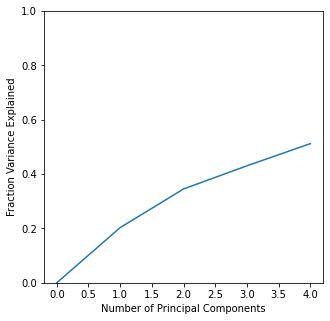

In [155]:
# PCA for the 15 shortlist features
pca_shortlist15 = pca_model(features15, 4) # input data and number of components

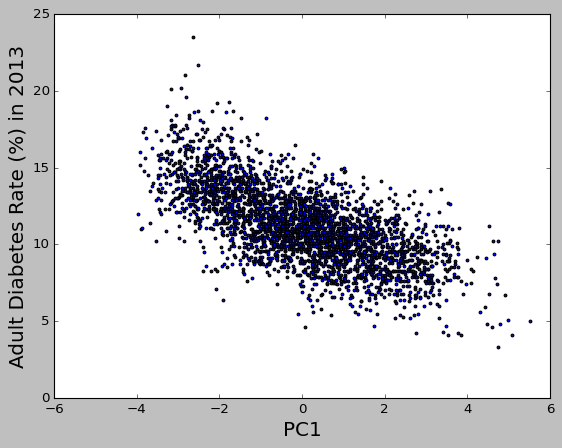

In [278]:
plt.style.use('classic')
plt.scatter(pca_shortlist15[:,0],df.PCT_DIABETES_ADULTS13,s=6)
plt.xlabel('PC1',fontsize=18)
plt.ylabel('Adult Diabetes Rate (%) in 2013',fontsize=18)
plt.savefig('Figs/PC1_diabetes.png')

Variance explained by first 3 components: 0.5085295582722906


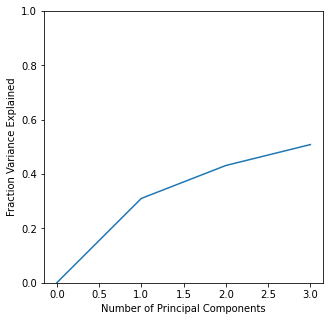

In [160]:
# PCA for 45 LOCAL variables 
pca_local = pca_model(local, 3)

Variance explained by first 2 components: 0.61029759466931


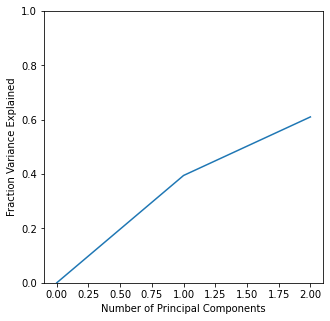

In [159]:
# PCA for 6 Restaurants variables 
pca_restaurants = pca_model(restaurants, 2)

Variance explained by first 2 components: 0.6641885870340662


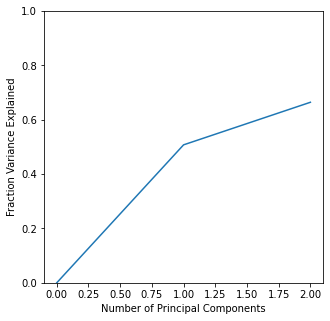

In [161]:
# PCA for 12 Stores variables
pca_stores = pca_model(stores, 2)

**Summary**  
For the group of 15 shortlist features, the first four PCs explained 51% of variance. Higher PC1 values is correlated with lower diabetes rate. For the ‘Local’ group, first three PCs explained 51% variance; for the ‘Restaurants’ and ‘Stores’ groups, the first two PCs explained 61% and 66% variances, respectively. 

## 5.2 K-means clustering

In [171]:
# Apply K means clustering to the first two PC components of each of the four groups analyzed above
from scipy import cluster
# https://docs.scipy.org/doc/scipy/reference/cluster.vq.html#module-scipy.cluster.vq

In [219]:
# %load functions/kmeans_model.py
def kmeans_model(PCs, clusters, title):
    '''Conduct K-means clustering, make elbow plot, 
    clustering plot with PC1, PC2, 
    and return clustering assignment'''
    from scipy import cluster
    # Use PC1 and PC2 for kmeans clustering, looping through 1 to 6 clusters
    df = [cluster.vq.kmeans(PCs[:, 0:2], i) for i in range(1,7)]

    # Figure 1: Elbow plot
    figure1 = plt.scatter(x=list(range(1,7)),
                y=[var for (cent, var) in df])
    plt.xlabel('Number of clusters')
    plt.ylabel('Average Euclidean distance between \n observations and centroids')
    plt.show()

    # Figure 2: Visualize clusters with PC1 and PC2
    cent, var = df[clusters-1] # choose number of clusters
    # use vq() to get as assignment for each obs.
    assignment, cdist = cluster.vq.vq(PCs[:, 0:2], cent)
    plt.style.use('classic')
    figure2 = plt.scatter(PCs[:,0], PCs[:,1], c=assignment) # Plot PC1 and PC2
    plt.xlabel('PC1', fontsize=18)
    plt.ylabel('PC2', fontsize=18)
    plt.title('Clustering for {}'.format(title), fontsize=18)
    
    return assignment

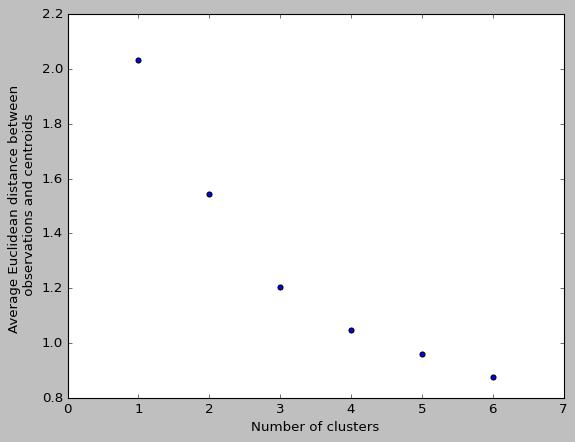

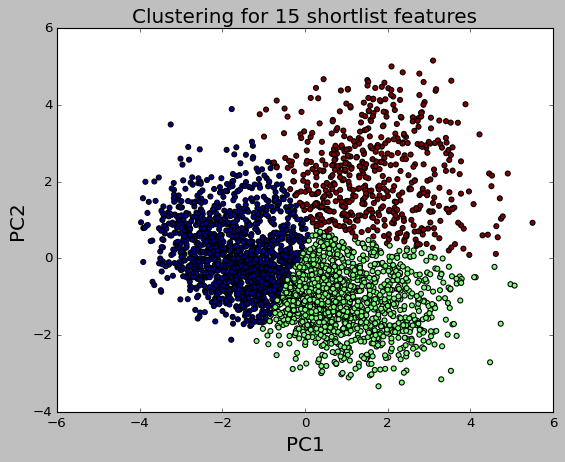

In [223]:
# K-means clustering for 15 shortlist features
kmeans_shortlist15 = kmeans_model(pca_shortlist15, 3, '15 shortlist features')

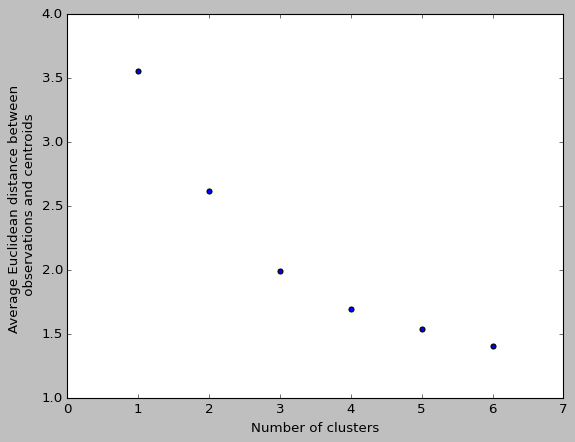

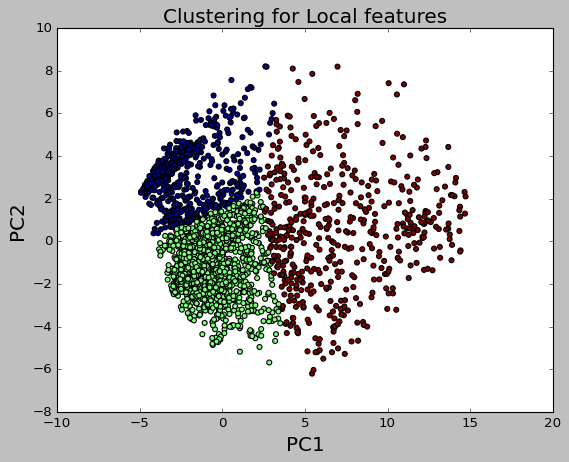

In [224]:
# K-means clustering for Local features
kmeans_locals = kmeans_model(pca_local, 3, 'Local features')

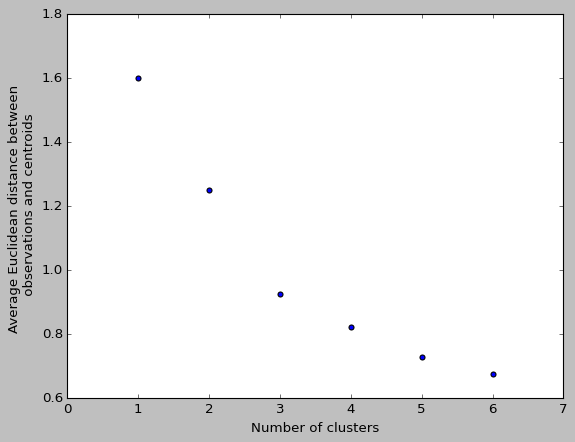

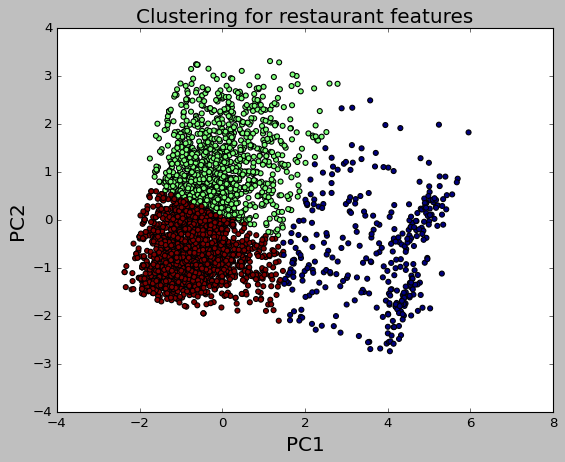

In [225]:
# K-means clustering for restaurants features
kmeans_restaurants = kmeans_model(pca_restaurants, 3, 'restaurant features')

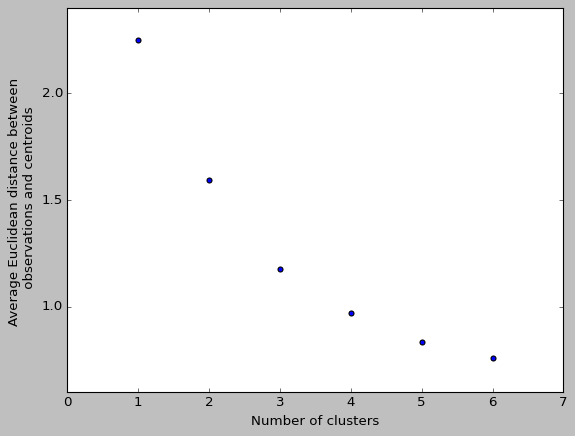

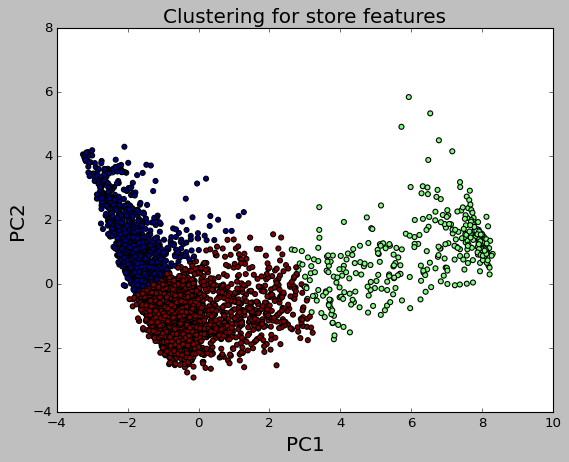

In [226]:
# K-means clustering for 12 store features
kmeans_stores = kmeans_model(pca_stores, 3, 'store features')

Next, let us visualize the geographic locations of counties and their cluster assignments, to see if there is any similarities (e.g.,geographic proximity) for counties belonging to the same cluster.

### Visualize clusters by US counties

In [212]:
import plotly.figure_factory as ff

# if auto-generate colors
# from colour import Color
# start = Color("orange")
#colors = list(start.range_to(Color("lightyellow"),3))
#colorscale = [str(color) for color in colors] 
colorscale = ['#ffe670','orange', 'LightYellow'] # customize color order
fips = df_winsorized['FIPS'].tolist()


In [213]:
colorscale

['#ffe670', 'orange', 'LightYellow']

In [269]:
# %load functions/choropleth.py
def counties_choropleth(assignment, color, fip, name):
    '''Create U.S. counties map and color each county by clutering assignments'''
    import plotly.figure_factory as ff

    fig = ff.create_choropleth(
            fips = fips, values = [str(i+1) for i in assignment], scope=['usa'],
        colorscale = color,
        title = 'Three clusters among U.S. counties based on {}'.format(name))

    return fig

In [270]:
map_shortlist = counties_choropleth(kmeans_shortlist15, colorscale, fips,'15 shortlist features')

In [268]:
map_shortlist.write_image('Figs/map-15features0420.png')

<img src="Figs/map-15features0420.png">

In [272]:
map_locals = counties_choropleth(kmeans_locals, colorscale, fips,'local features')

In [273]:
map_locals.write_image('Figs/map-locals0420.png')

<img src='Figs/map-locals0420.png'>

In [275]:
map_restaurants = counties_choropleth(kmeans_restaurants, colorscale, fips,'restaurant features')

In [274]:
map_restaurants.write_image('Figs/map-restaurants0420.png')

<img src='Figs/map-restaurants0420.png'>

In [277]:
map_stores = counties_choropleth(kmeans_stores, colorscale, fips,'store features')

In [276]:
map_stores.write_image('Figs/map-stores0420.png')

<img src='Figs/map-stores0420.png'>

**Summary**  
Principal components from PCA on 15 focal features revealed three major clusters of U.S. counties. The counties located at central south and southeast forms one cluster, featuring higher poverty rate and diabetes rate; counties at west and east coast and the great lakes area forms a second cluster, which have lower poverty rate and diabetes rate. The rest of counties forms the third cluster. Clusters on restaurant features are distinct between the north and the south. On the contrary, clusters on local features and store features did not show obvious geographic trend. 